In [1]:
from utilities import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import aesara.tensor as at
from create_training_instance_dictionary_with_covariates import *
from feature_extraction import *
from sample_from_full_model import *
# Initialize random number generator
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.2.2


In [2]:
# Generate simulated data with interactions 
true_sigma_obs = 0.1
N_patients = 100

# True parameter values
P = 6 # Number of covariates
P0 = int(P / 2) # A guess of the true number of nonzero parameters is needed for defining the global shrinkage parameter
X_mean = np.repeat(0,P)
X_std = np.repeat(0.5,P)
#X = np.random.normal(X_mean, X_std, size=(N_patients,P))
X = np.random.uniform(-1, 1, size=(N_patients,P))
X = pd.DataFrame(X, columns = ["Covariate "+str(ii+1) for ii in range(P)])
# These are the true parameters for x1 = 0 (median):
rho_s_population = -0.005
rho_r_population = 0.001
pi_r_population = 0.4
psi_population = 50
theta_rho_s_population_for_x_equal_to_zero = np.log(-rho_s_population)
theta_rho_r_population_for_x_equal_to_zero = np.log(rho_r_population)
theta_pi_r_population_for_x_equal_to_zero  = np.log(pi_r_population/(1-pi_r_population))

true_omega = np.array([0.05, 0.10, 0.15])
true_alpha = np.array([theta_rho_s_population_for_x_equal_to_zero, theta_rho_r_population_for_x_equal_to_zero, theta_pi_r_population_for_x_equal_to_zero])
true_beta_rho_s = np.zeros(P)
true_beta_rho_s[0] = 0.8
true_beta_rho_s[1] = 0
true_beta_rho_r = np.zeros(P)
true_beta_rho_r[0] = 0.7
true_beta_rho_r[1] = 1.0
true_beta_pi_r = np.zeros(P)
true_beta_pi_r[0] = 0
true_beta_pi_r[1] = 0

print("true_alpha[0]:", true_alpha[0])
print("true_alpha[1]:", true_alpha[1])
print("true_alpha[2]:", true_alpha[2])
print("true_beta_rho_s: ", true_beta_rho_s)
print("true_beta_rho_r: ", true_beta_rho_r)
print("true_beta_pi_r: ", true_beta_pi_r)

# This could be a function: 
#   X, patient_dictionary = generate_simulated_patients(M_number_of_measurements, days_between_measurements, measurement_times, treatment_history, interaction_beta)

M_number_of_measurements = 5
days_between_measurements = int(1500/M_number_of_measurements)
measurement_times = days_between_measurements * np.linspace(0, M_number_of_measurements-1, M_number_of_measurements)
treatment_history = np.array([Treatment(start=0, end=measurement_times[-1], id=1)])

interaction_beta = -1

expected_theta_1 = np.reshape(true_alpha[0] + np.dot(X, true_beta_rho_s), (N_patients,1))
print((true_alpha[0] + np.dot(X, true_beta_rho_s)).shape)
print((interaction_beta*X["Covariate 1"]*(X["Covariate 2"].T)).shape)
print(expected_theta_1.shape)
expected_theta_1 = np.reshape(true_alpha[0] + np.dot(X, true_beta_rho_s) + np.ravel(interaction_beta*X["Covariate 1"]*(X["Covariate 2"].T)), (N_patients,1))
print(expected_theta_1.shape)
expected_theta_2 = np.reshape(true_alpha[1] + np.dot(X, true_beta_rho_r), (N_patients,1))
expected_theta_3 = np.reshape(true_alpha[2] + np.dot(X, true_beta_pi_r), (N_patients,1))

true_theta_rho_s = np.random.normal(expected_theta_1, true_omega[0])
true_theta_rho_r = np.random.normal(expected_theta_2, true_omega[1])
true_theta_pi_r  = np.random.normal(expected_theta_3, true_omega[2])

true_omega_for_psi = 0.1
true_theta_psi = np.random.normal(np.log(psi_population), true_omega_for_psi, size=N_patients)
true_rho_s = - np.exp(true_theta_rho_s)
true_rho_r = np.exp(true_theta_rho_r)
true_pi_r  = 1/(1+np.exp(-true_theta_pi_r))
true_psi = np.exp(true_theta_psi)

patient_dictionary = {}
for training_instance_id in range(N_patients):
    psi_patient_i   = true_psi[training_instance_id]
    pi_r_patient_i  = true_pi_r[training_instance_id]
    rho_r_patient_i = true_rho_r[training_instance_id]
    rho_s_patient_i = true_rho_s[training_instance_id]
    these_parameters = Parameters(Y_0=psi_patient_i, pi_r=pi_r_patient_i, g_r=rho_r_patient_i, g_s=rho_s_patient_i, k_1=0, sigma=true_sigma_obs)
    this_patient = Patient(these_parameters, measurement_times, treatment_history, name=str(training_instance_id))
    patient_dictionary[training_instance_id] = this_patient
    #plot_true_mprotein_with_observations_and_treatments_and_estimate(these_parameters, this_patient, estimated_parameters=[], PLOT_ESTIMATES=False, plot_title=str(training_instance_id), savename="./plots/Bayes_simulated_data/"+str(training_instance_id))

true_alpha[0]: -5.298317366548036
true_alpha[1]: -6.907755278982137
true_alpha[2]: -0.4054651081081643
true_beta_rho_s:  [0.8 0.  0.  0.  0.  0. ]
true_beta_rho_r:  [0. 0. 0. 0. 0. 0.]
true_beta_pi_r:  [0. 0. 0. 0. 0. 0.]
(100,)
(100,)
(100, 1)
(100, 1)


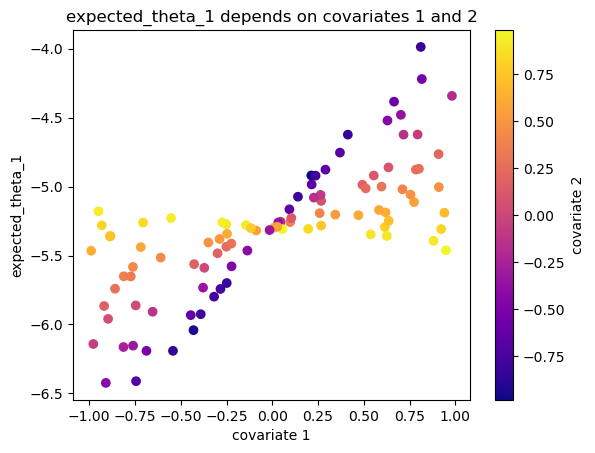

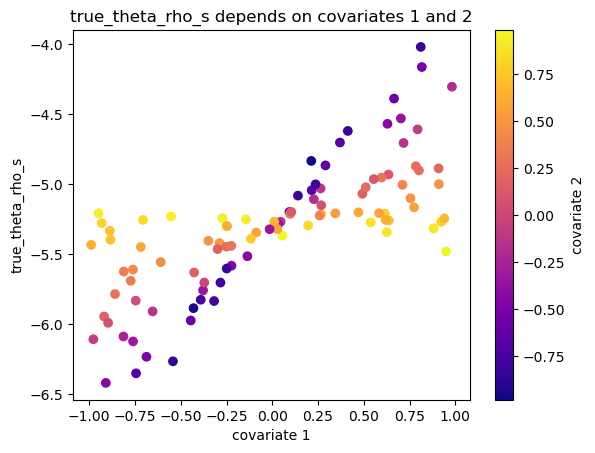

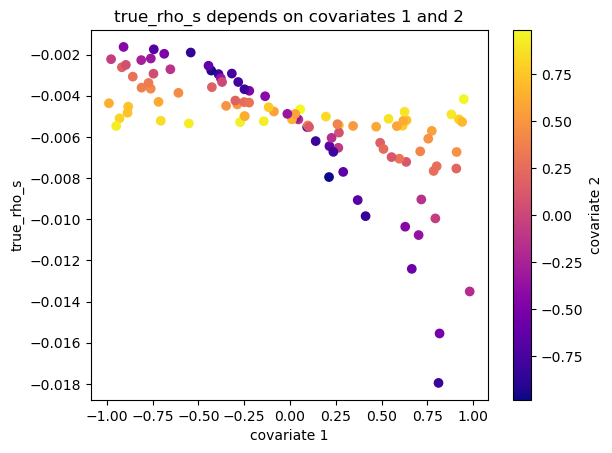

In [3]:
# Visualize parameter dependancy on covariates 
VISZ = True
if VISZ:
    color_array = X["Covariate 2"].to_numpy()

    fig, ax = plt.subplots()
    ax.set_title("expected_theta_1 depends on covariates 1 and 2")
    points = ax.scatter(X["Covariate 1"], expected_theta_1, c=color_array, cmap="plasma")
    ax.set_xlabel("covariate 1")
    ax.set_ylabel("expected_theta_1")
    cbar = fig.colorbar(points)
    cbar.set_label('covariate 2', rotation=90)
    plt.show()

    fig, ax = plt.subplots()
    ax.set_title("true_theta_rho_s depends on covariates 1 and 2")
    points = ax.scatter(X["Covariate 1"], true_theta_rho_s, c=color_array, cmap="plasma")
    ax.set_xlabel("covariate 1")
    ax.set_ylabel("true_theta_rho_s")
    cbar = fig.colorbar(points)
    cbar.set_label('covariate 2', rotation=90)
    plt.show()

    fig, ax = plt.subplots()
    ax.set_title("true_rho_s depends on covariates 1 and 2")
    points = ax.scatter(X["Covariate 1"], true_rho_s, c=color_array, cmap="plasma")
    ax.set_xlabel("covariate 1")
    ax.set_ylabel("true_rho_s")
    cbar = fig.colorbar(points)
    cbar.set_label('covariate 2', rotation=90)
    plt.show()

In [4]:
# Transpose and check that dimensions are correct
Y = np.transpose(np.array([patient.Mprotein_values for _, patient in patient_dictionary.items()]))
t = np.transpose(np.array([patient.measurement_times for _, patient in patient_dictionary.items()]))
yi0 = np.array([patient.Mprotein_values[0] for _, patient in patient_dictionary.items()])
yi0 = np.maximum(yi0, 1e-5)
#print("Y:\n", Y)
#print("t:\n", t)
#print("yi0:\n", yi0)
#print("X:\n", X)
X_not_transformed = X.copy().T
print(X_not_transformed.columns.values)
#X = X.T
print("Shapes:")
print("Y:", Y.shape)
print("t:", t.shape)
print("yi0:", yi0.shape)
print("X:", X.shape)
print("Done generating data")

assert X.shape[0] == len(patient_dictionary)
N_cases, P = X.shape
print("N_cases:", N_cases)
print(patient_dictionary[0].treatment_history[-1].end)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Shapes:
Y: (5, 100)
t: (5, 100)
yi0: (100,)
X: (100, 6)
Done generating data
N_cases: 100
1200.0


In [5]:
# Check that histories stop at the last M protein measurement
print(patient_dictionary[0].treatment_history[-1].end)
print(patient_dictionary[0].measurement_times[-1])

1200.0
1200.0


Runningsimdata_linear_M_5_P_6_N_cases_100_psi_prior_normal_N_samples_3000_N_tuning_3000_target_accept_0.99_max_treedepth_10_FUNNEL_REPARAMETRIZATION_False
Max(Y): 102.59393105119125
Max(t): 1200.0


Sampling: [Y_obs, alpha, c2_pi_r, c2_rho_r, c2_rho_s, lam_pi_r, lam_rho_r, lam_rho_s, omega, psi, sigma_obs, tau_pi_r, tau_rho_r, tau_rho_s, theta_pi_r, theta_rho_r, theta_rho_s, z_pi_r, z_rho_r, z_rho_s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, alpha, tau_rho_s, tau_rho_r, tau_pi_r, lam_rho_s, lam_rho_r, lam_pi_r, c2_rho_s, c2_rho_r, c2_pi_r, z_rho_s, z_rho_r, z_pi_r, omega, theta_rho_s, theta_rho_r, theta_pi_r, psi]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 3594 seconds.


Done sampling


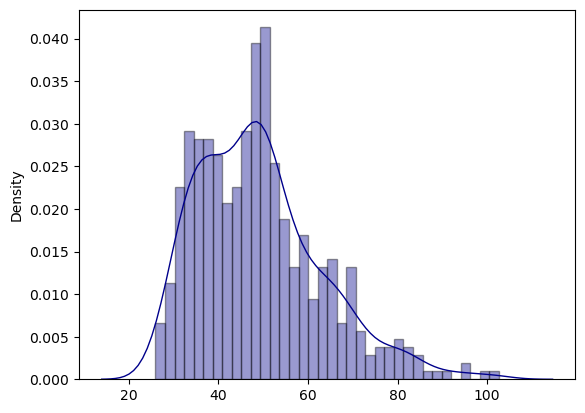

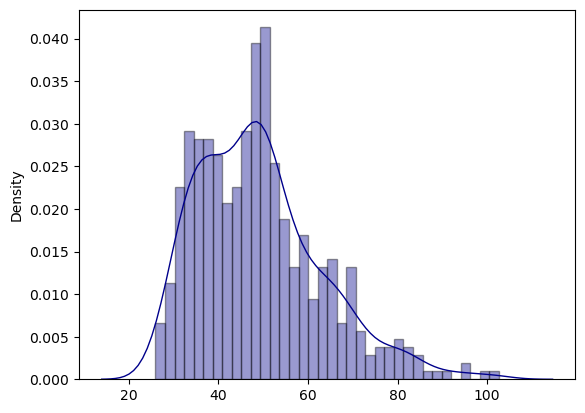

In [6]:
# Sample from full model
psi_prior="normal"
N_samples = 3000
N_tuning = 3000
target_accept = 0.99
max_treedepth = 10
FUNNEL_REPARAMETRIZATION = False
name = "simdata_linear_M_"+str(M_number_of_measurements)+"_P_"+str(P)+"_N_cases_"+str(N_cases)+"_psi_prior_"+psi_prior+"_N_samples_"+str(N_samples)+"_N_tuning_"+str(N_tuning)+"_target_accept_"+str(target_accept)+"_max_treedepth_"+str(max_treedepth)+"_FUNNEL_REPARAMETRIZATION_"+str(FUNNEL_REPARAMETRIZATION)
print("Running"+name)
idata = sample_from_full_model(X, patient_dictionary, name, N_samples=N_samples, N_tuning=N_tuning, target_accept=target_accept, max_treedepth=max_treedepth, psi_prior=psi_prior, FUNNEL_REPARAMETRIZATION=FUNNEL_REPARAMETRIZATION)
# This is an xArray: https://docs.xarray.dev/en/v2022.11.0/user-guide/data-structures.html
print("Done sampling")

In [7]:
# Convergence checks
def quasi_geweke_test(idata, first=0.1, last=0.5, intervals=20):
    print("Running Geweke test...")
    convergence_flag = True
    for var_name in ['alpha', 'beta_rho_s', 'beta_rho_r', 'beta_pi_r', 'omega', 'theta_rho_s', 'theta_rho_r', 'theta_pi_r', 'rho_s', 'rho_r', 'pi_r']:
        sample_shape = idata.posterior[var_name].shape
        n_chains = sample_shape[0]
        n_samples = sample_shape[1]
        var_dims = sample_shape[2]
        for chain in range(n_chains):
            for dim in range(var_dims):
                all_samples = np.ravel(idata.posterior[var_name][chain,:,dim])
                first_part = all_samples[0:int(n_samples*first)]
                last_part = all_samples[n_samples-int(n_samples*last):n_samples]
                z_score = (np.mean(first_part)-np.mean(last_part)) / np.sqrt(np.var(first_part)+np.var(last_part))
                if abs(z_score) >= 1.960:
                    convergence_flag = False
                    print("Seems like chain",chain,"has not converged in",var_name,"dimension",dim,": z_score is",z_score)
    for var_name in ['sigma_obs']:
        all_samples = np.ravel(idata.posterior[var_name])
        n_samples = len(all_samples)
        first_part = all_samples[0:int(n_samples*first)]
        last_part = all_samples[n_samples-int(n_samples*last):n_samples]
        z_score = (np.mean(first_part)-np.mean(last_part)) / np.sqrt(np.var(first_part)+np.var(last_part))
        if abs(z_score) >= 1.960:
            convergence_flag = False
            print("Seems like chain",chain,"has not converged in",var_name,"dimension",dim,": z_score is",z_score)
    if convergence_flag:
        print("All chains seem to have converged.")
    return 0

quasi_geweke_test(idata, first=0.1, last=0.5)

Running Geweke test...
All chains seem to have converged.


0

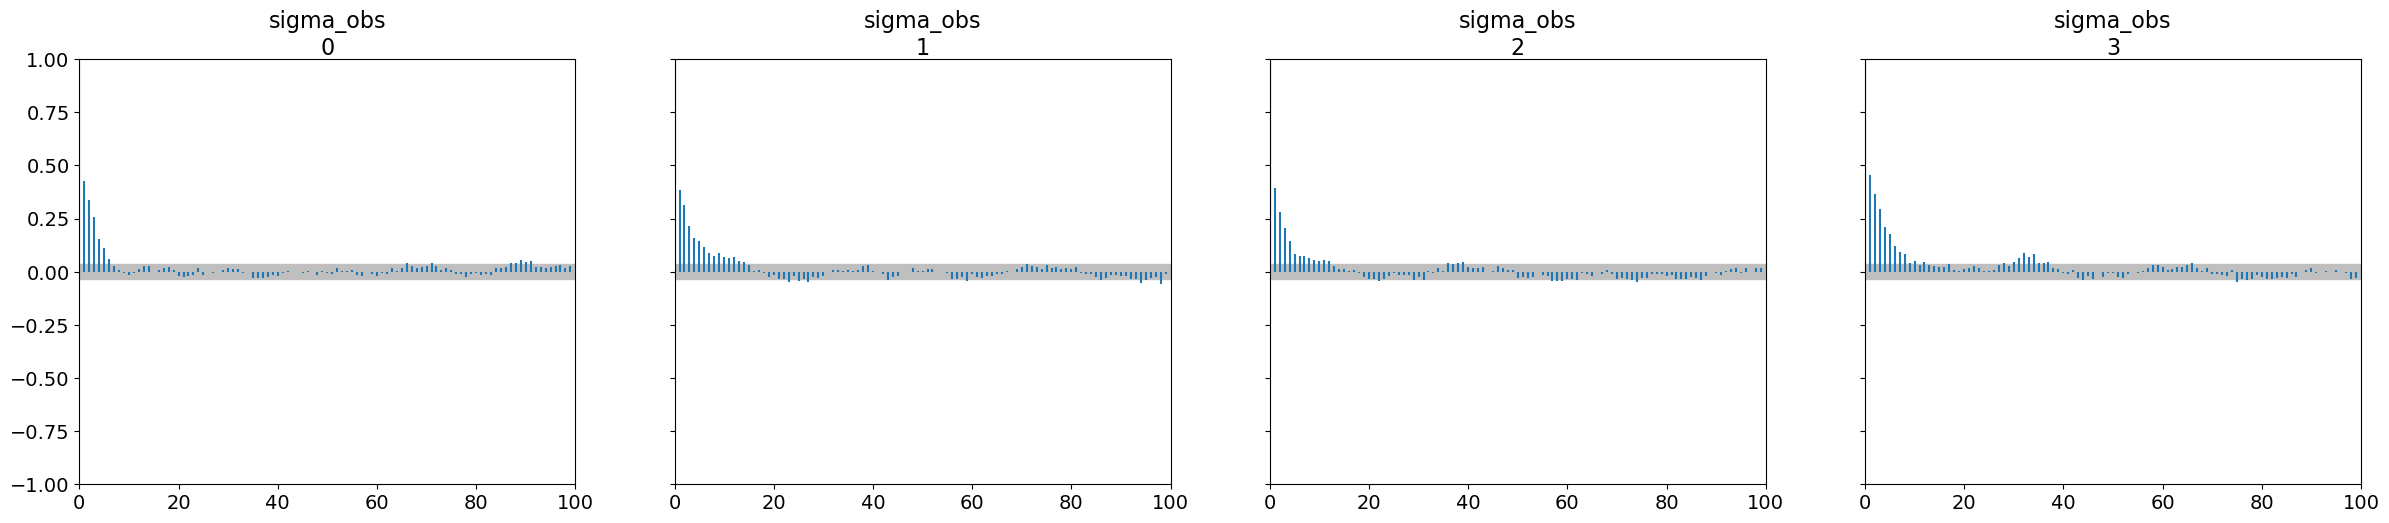

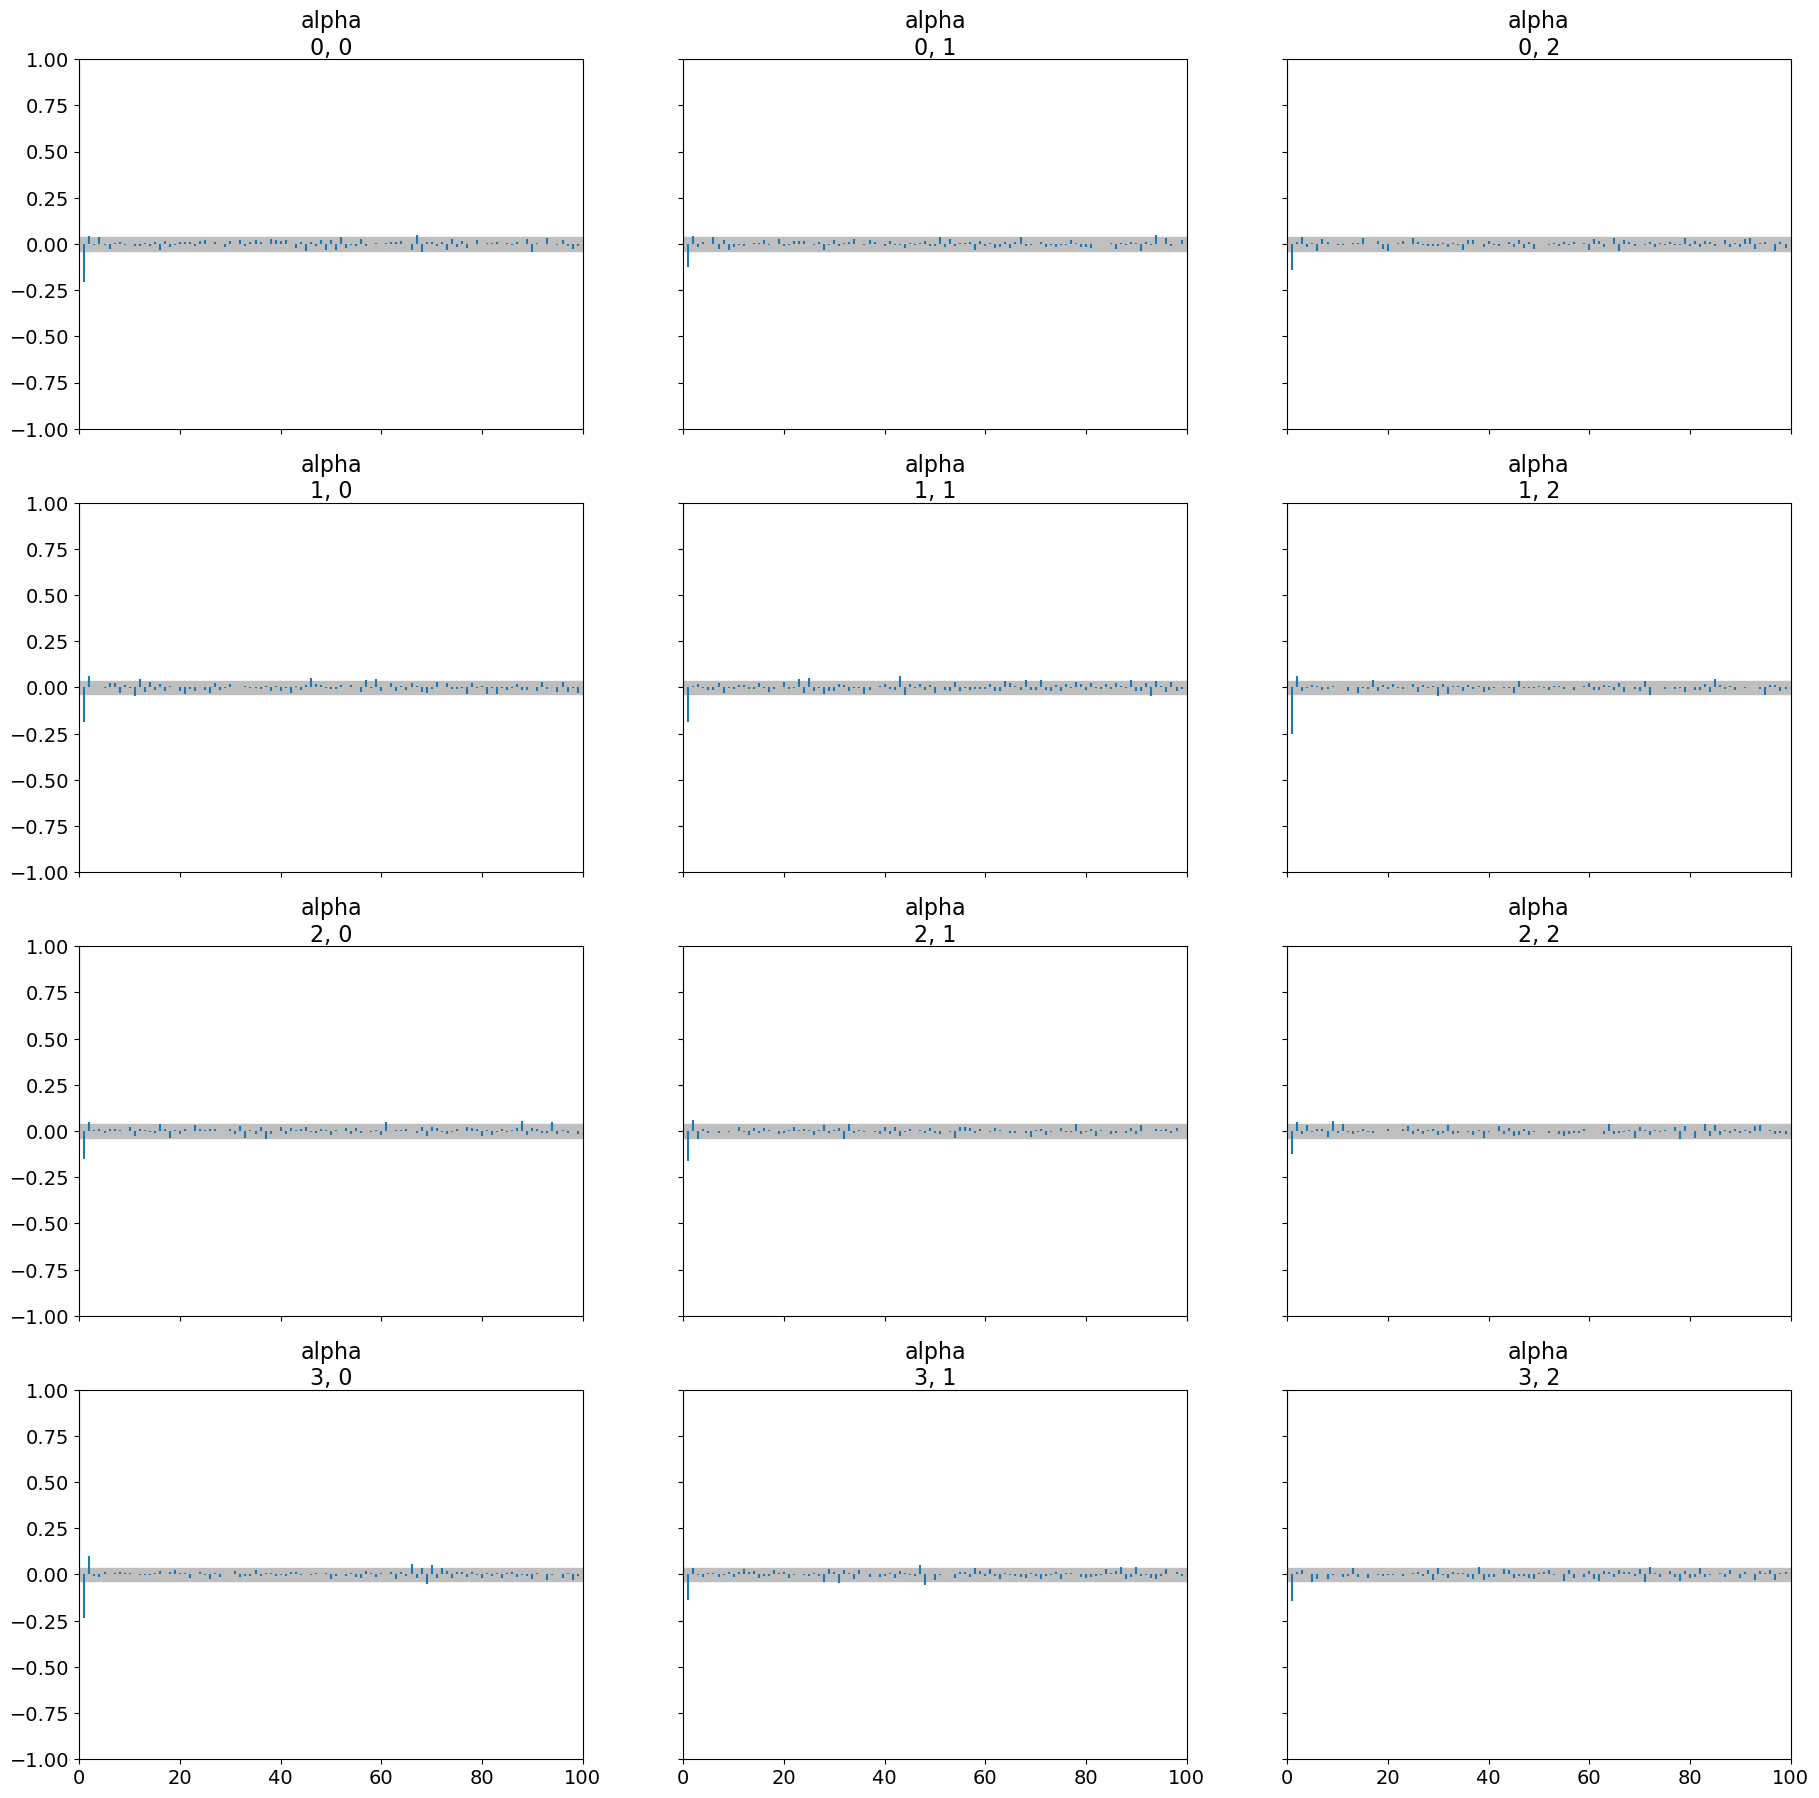

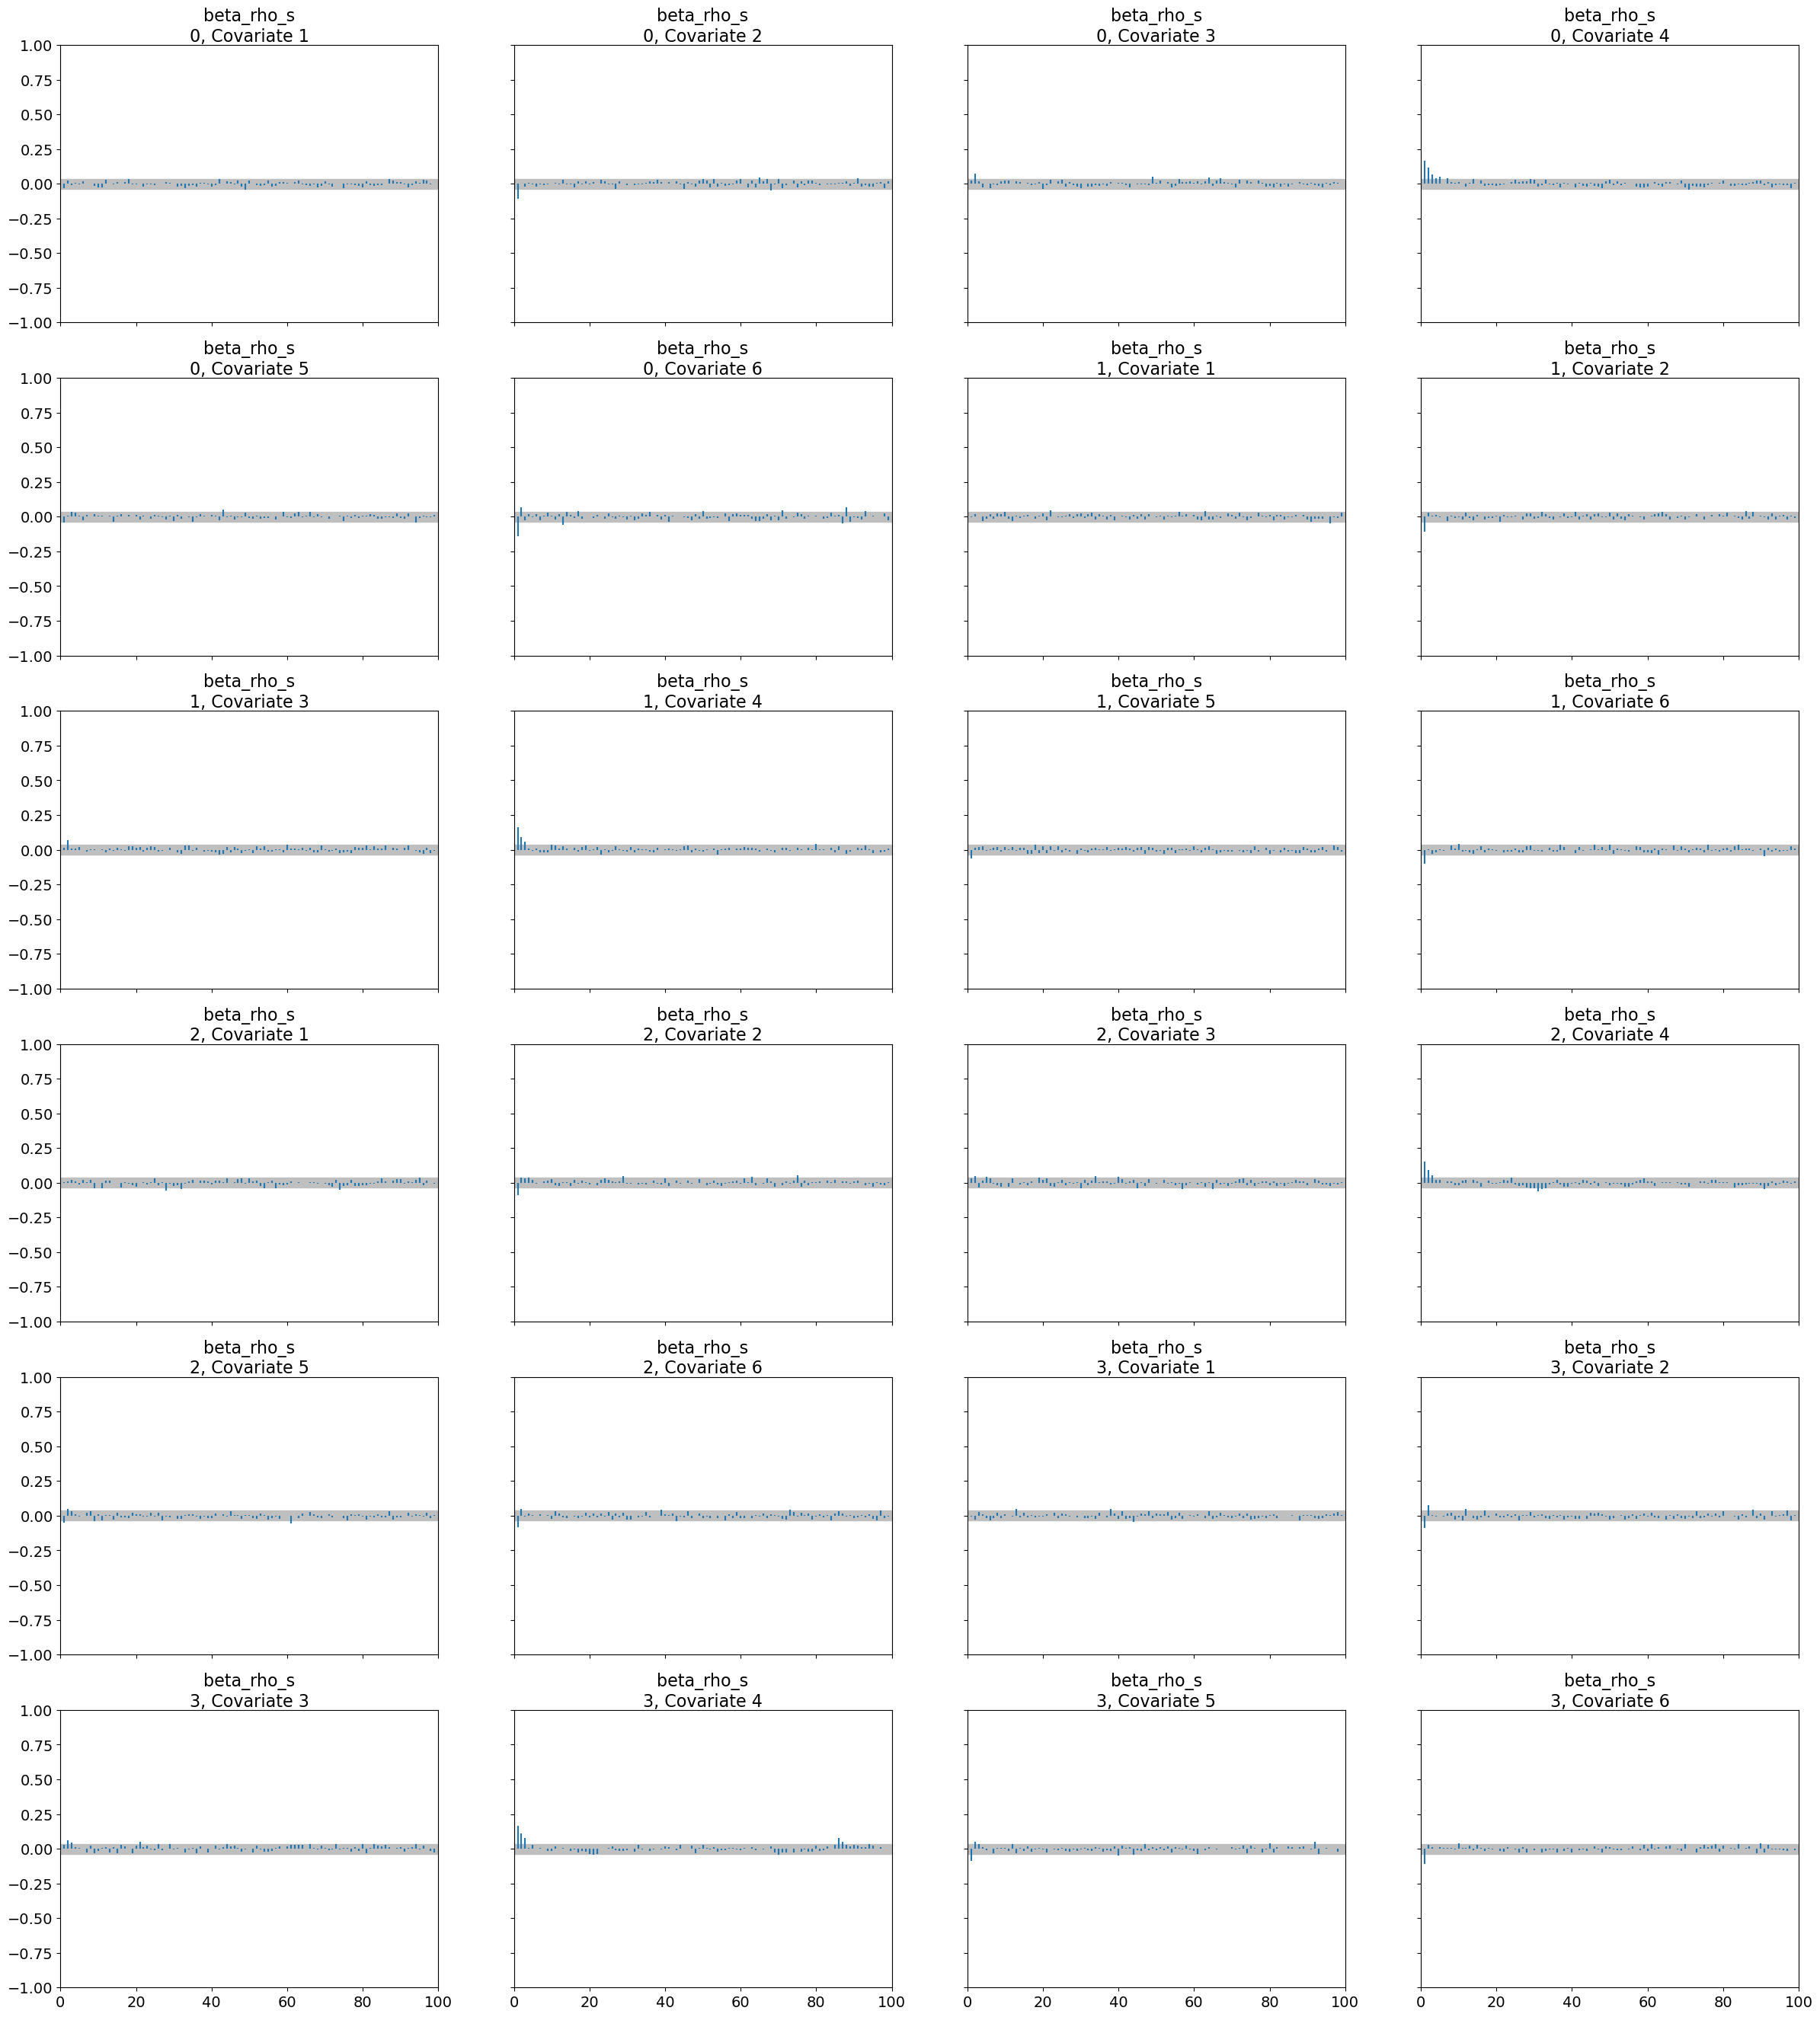

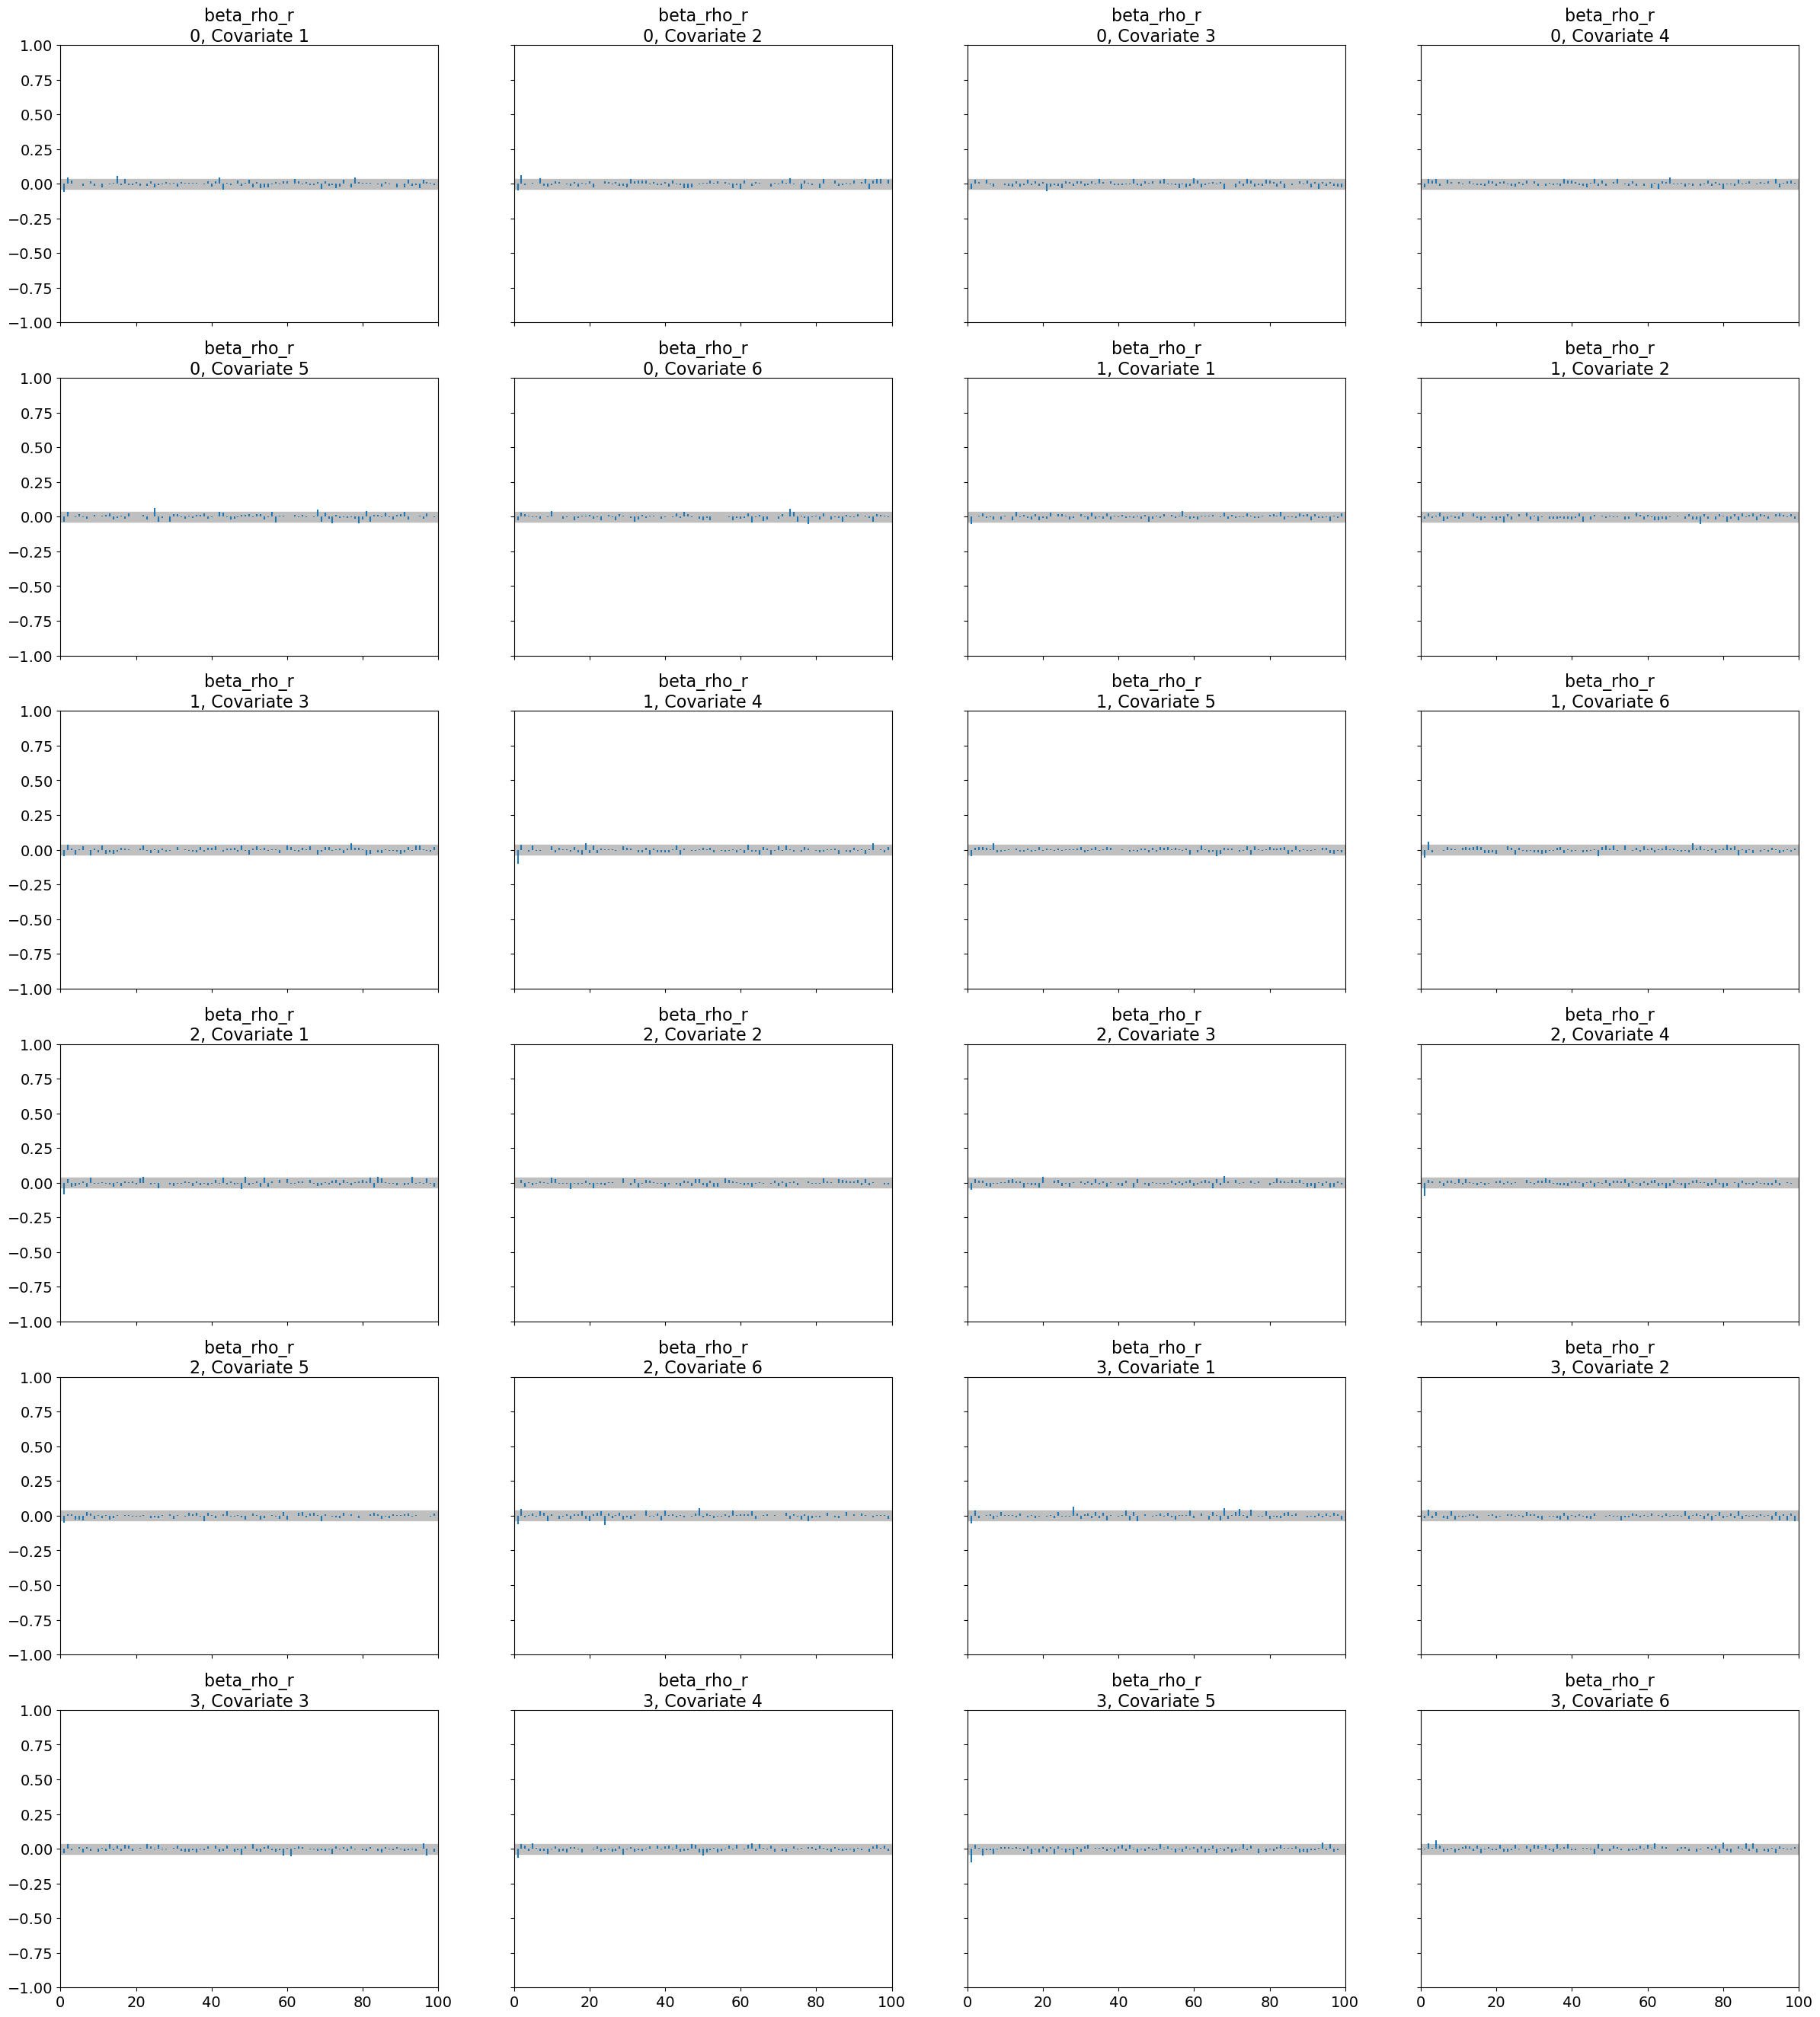

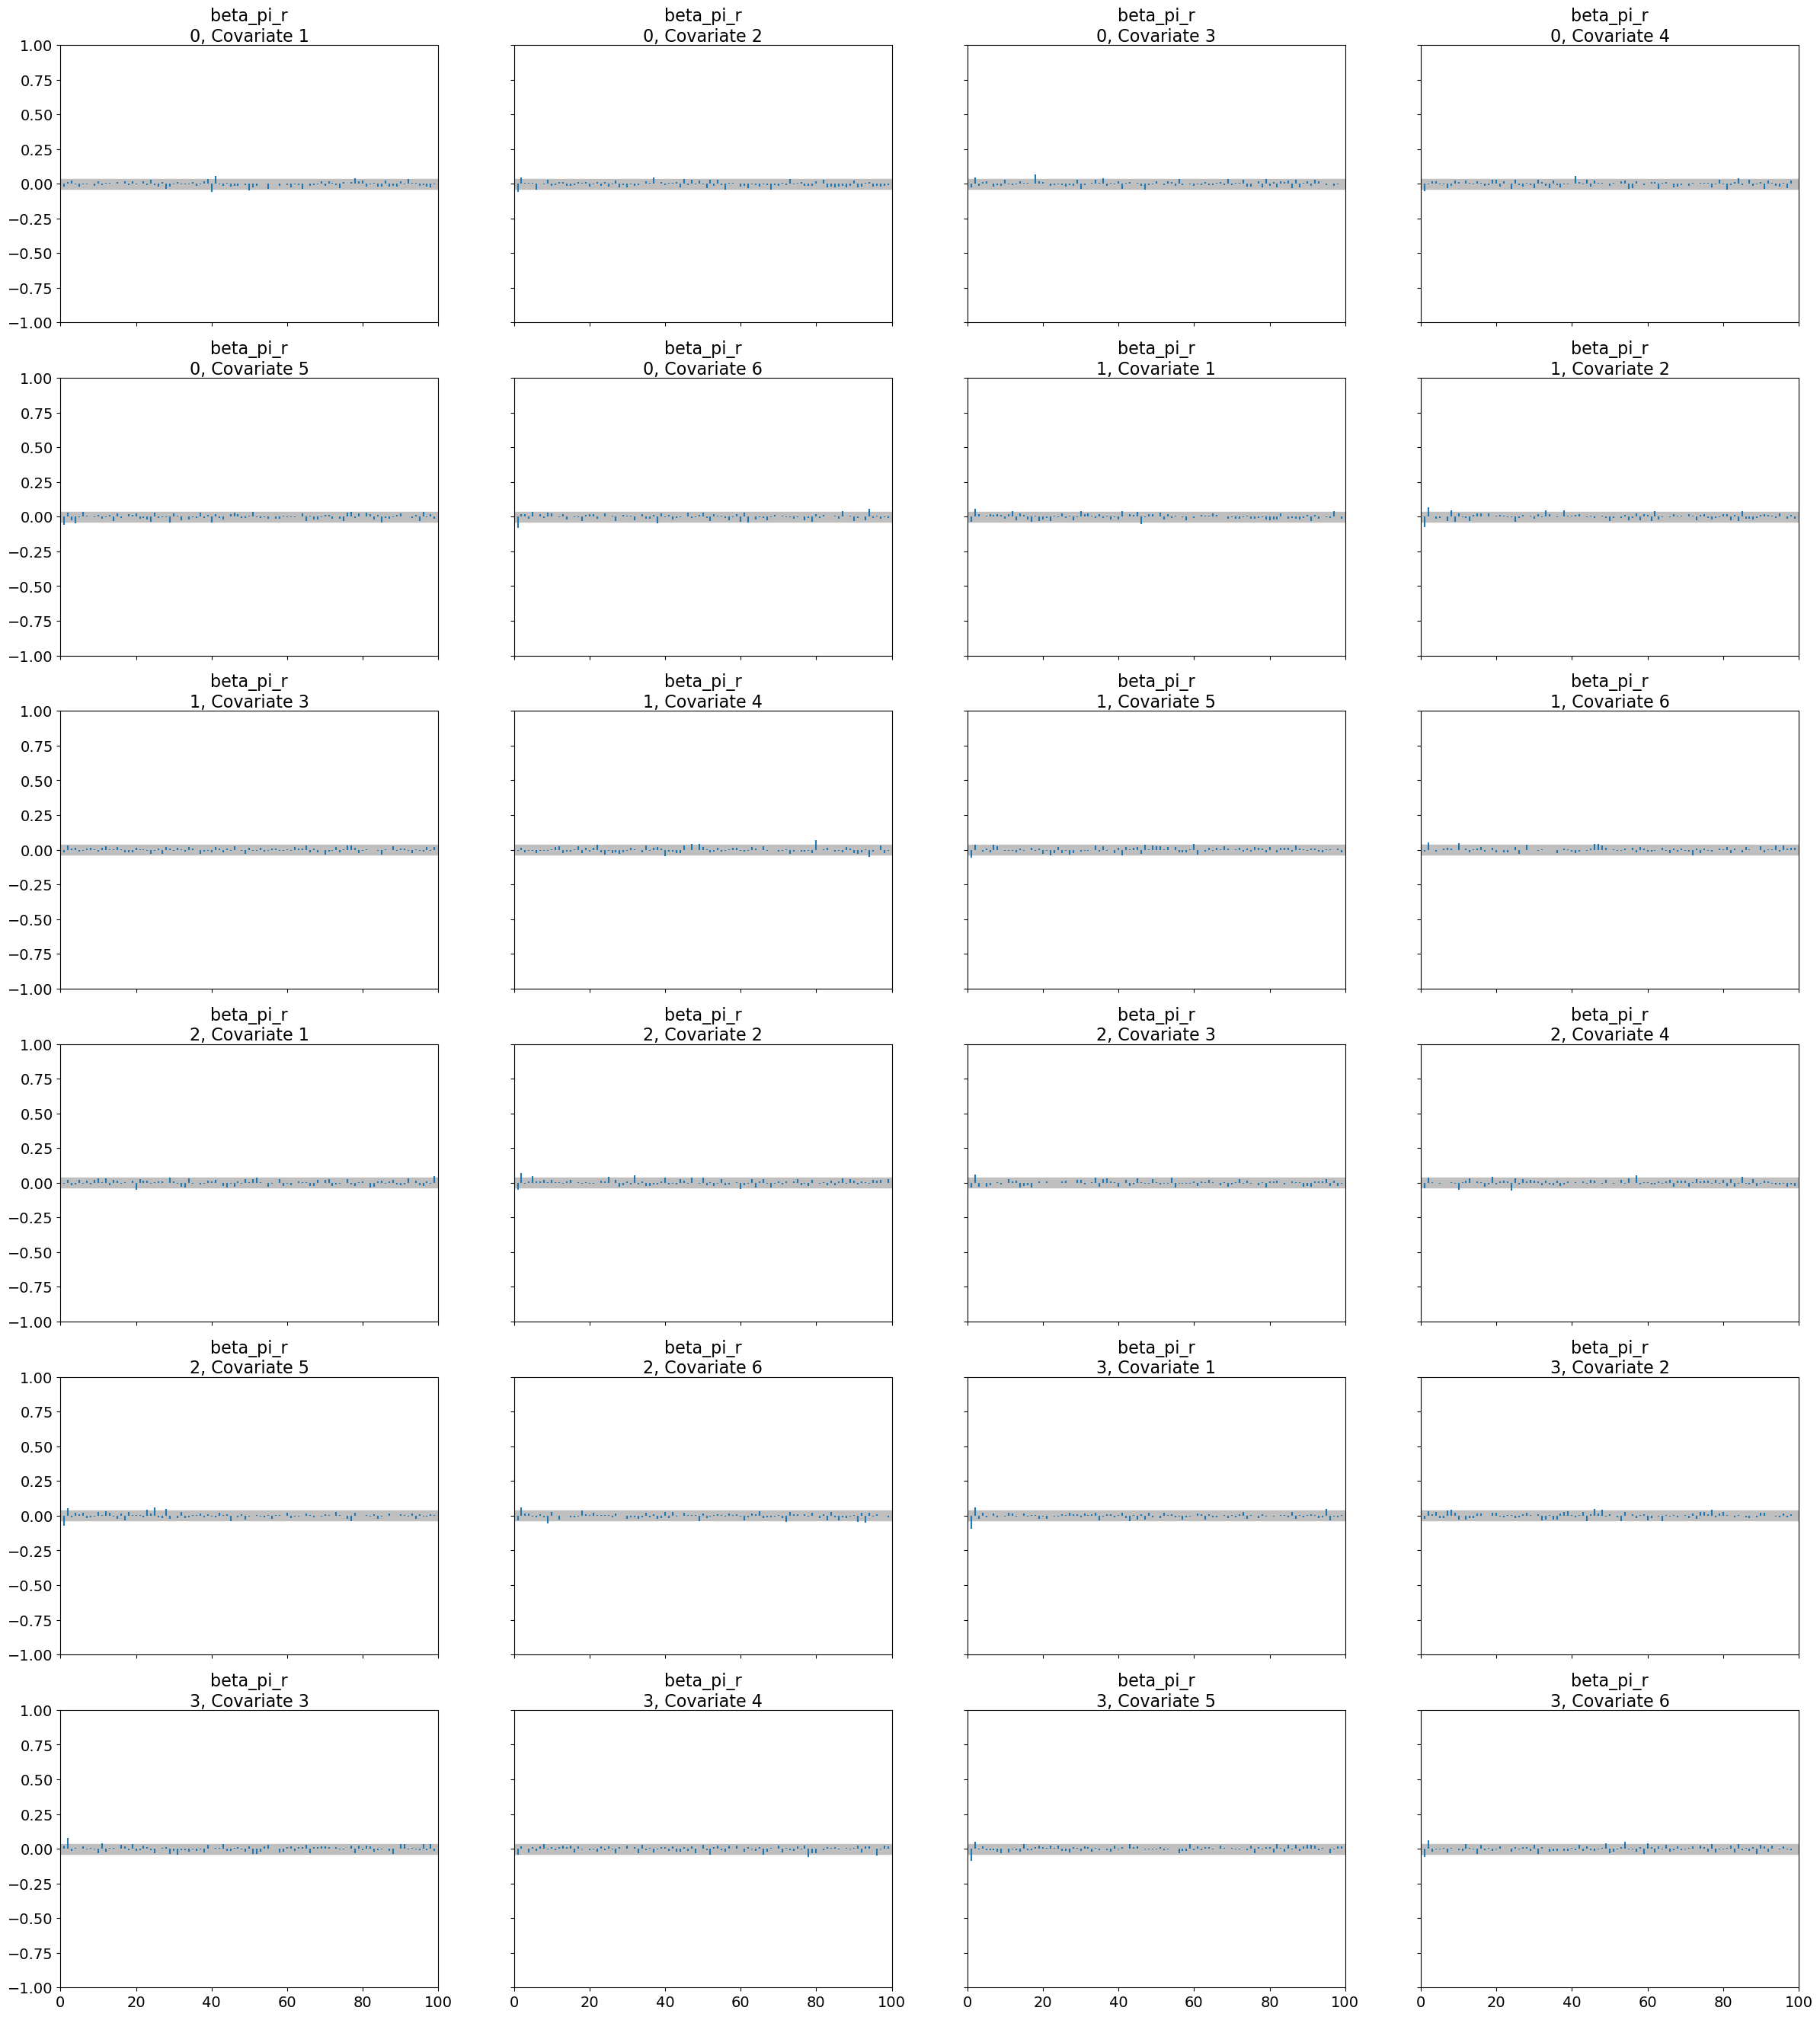

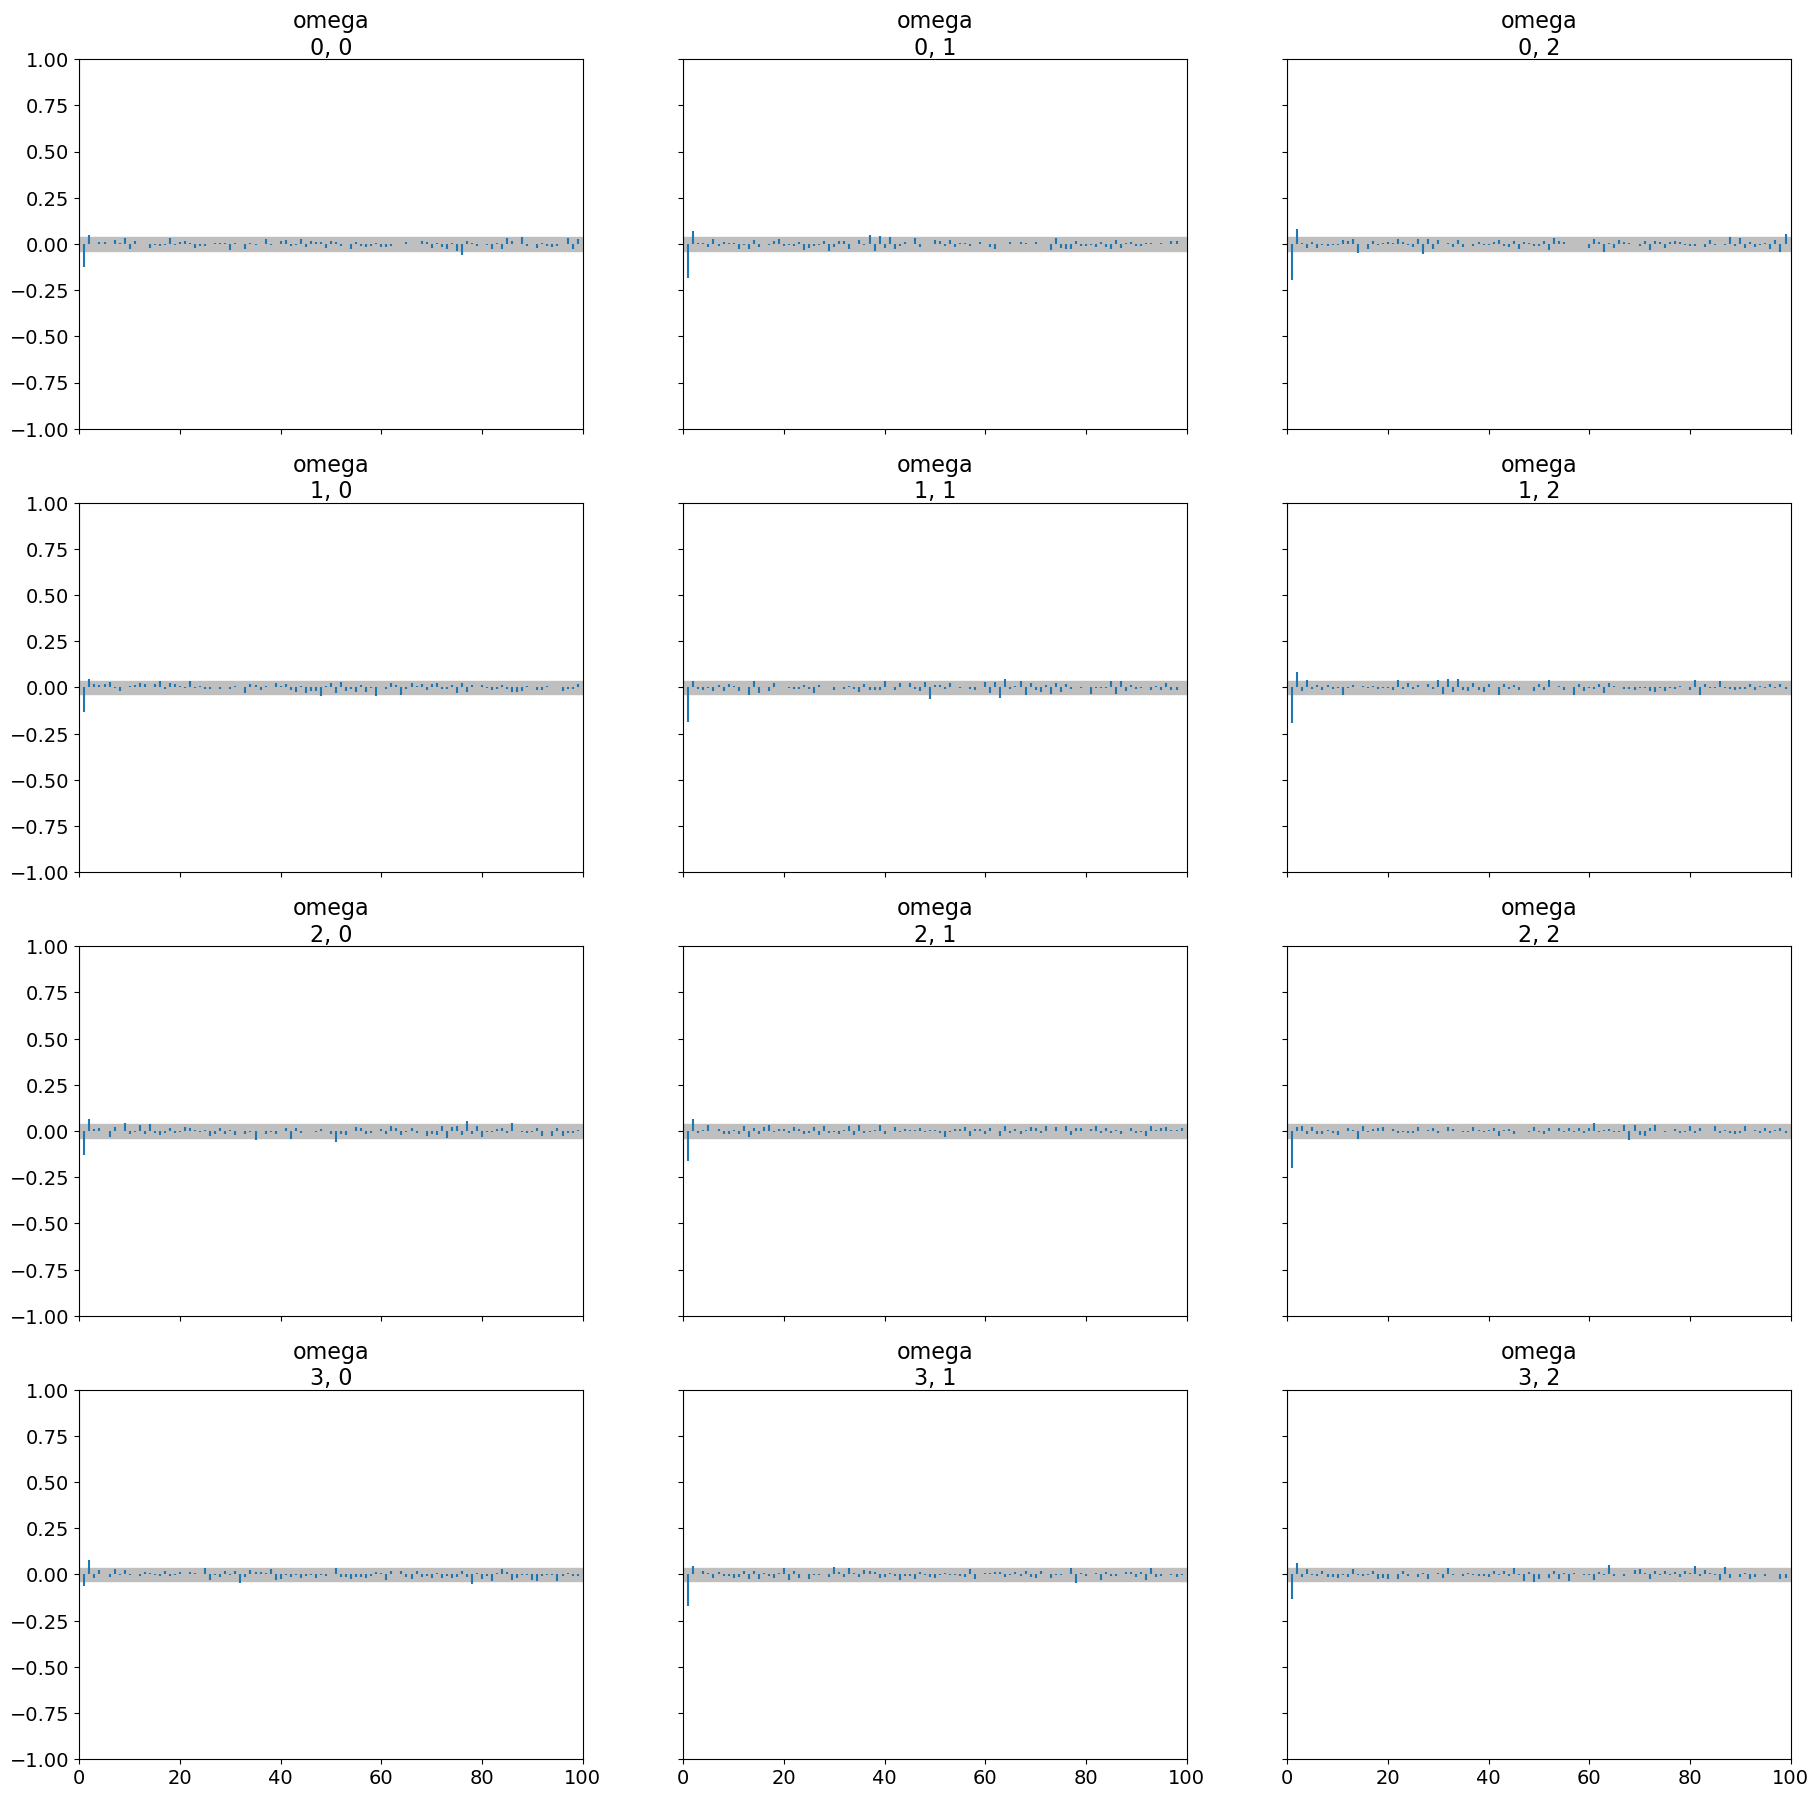

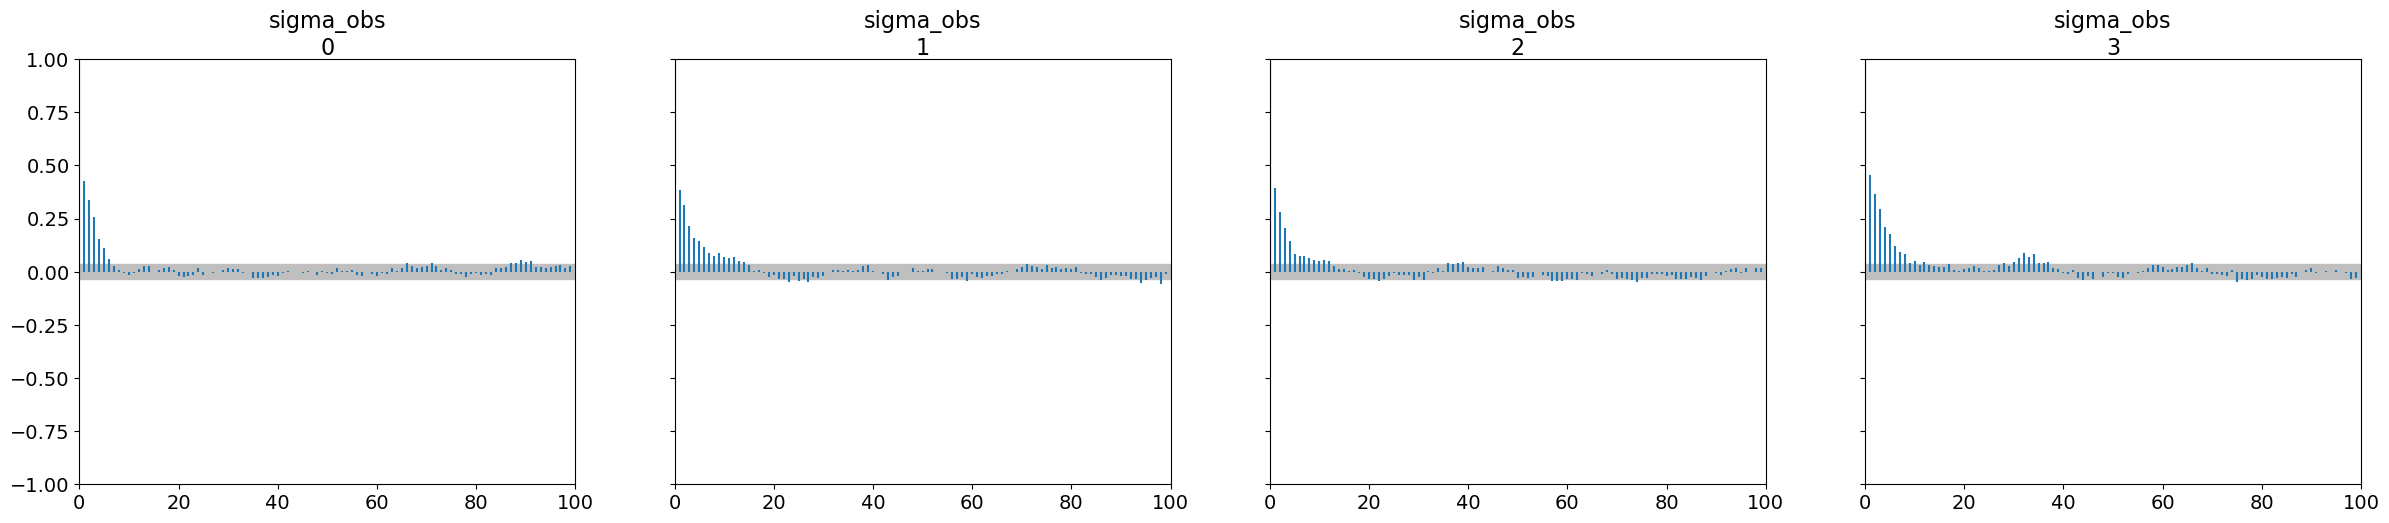

In [8]:
# Autocorrelation plots: 
az.plot_autocorr(idata, var_names=["sigma_obs"]);
az.plot_autocorr(idata, var_names=["alpha"]);
az.plot_autocorr(idata, var_names=["beta_rho_s"]);
az.plot_autocorr(idata, var_names=["beta_rho_r"]);
az.plot_autocorr(idata, var_names=["beta_pi_r"]);
az.plot_autocorr(idata, var_names=["omega"]);
az.plot_autocorr(idata, var_names=["sigma_obs"]);

In [9]:
# Posterior means 
print("List of covariates:", idata.posterior.coords['predictors'])
print('Posterior average of alpha:\n', np.mean(idata.posterior['alpha'], axis=(0,1)))
print('\nPosterior average of beta_rho_s:\n', np.mean(idata.posterior['beta_rho_s'], axis=(0,1)))
print('\nPosterior average of beta_rho_r:\n', np.mean(idata.posterior['beta_rho_r'], axis=(0,1)))
print('\nPosterior average of beta_pi_r:\n', np.mean(idata.posterior['beta_pi_r'], axis=(0,1)))
print('\nPosterior average of omega:\n', np.mean(idata.posterior['omega'], axis=(0,1)))
print('\nPosterior average of sigma_obs:\n', np.mean(idata.posterior['sigma_obs'], axis=(0,1)))

List of covariates: <xarray.DataArray 'predictors' (predictors: 6)>
array(['Covariate 1', 'Covariate 2', 'Covariate 3', 'Covariate 4',
       'Covariate 5', 'Covariate 6'], dtype='<U11')
Coordinates:
  * predictors  (predictors) <U11 'Covariate 1' 'Covariate 2' ... 'Covariate 6'
Posterior average of alpha:
 <xarray.DataArray 'alpha' (alpha_dim_0: 3)>
array([-5.31943832, -6.90399435, -0.42229337])
Coordinates:
  * alpha_dim_0  (alpha_dim_0) int64 0 1 2

Posterior average of beta_rho_s:
 <xarray.DataArray 'beta_rho_s' (predictors: 6)>
array([ 0.54477755,  0.00156456, -0.03488392,  0.07451063,  0.02127653,
        0.00360565])
Coordinates:
  * predictors  (predictors) <U11 'Covariate 1' 'Covariate 2' ... 'Covariate 6'

Posterior average of beta_rho_r:
 <xarray.DataArray 'beta_rho_r' (predictors: 6)>
array([ 0.00217236,  0.00088055, -0.00096775, -0.00388276,  0.00190109,
        0.001778  ])
Coordinates:
  * predictors  (predictors) <U11 'Covariate 1' 'Covariate 2' ... 'Covariate 6'

Poste

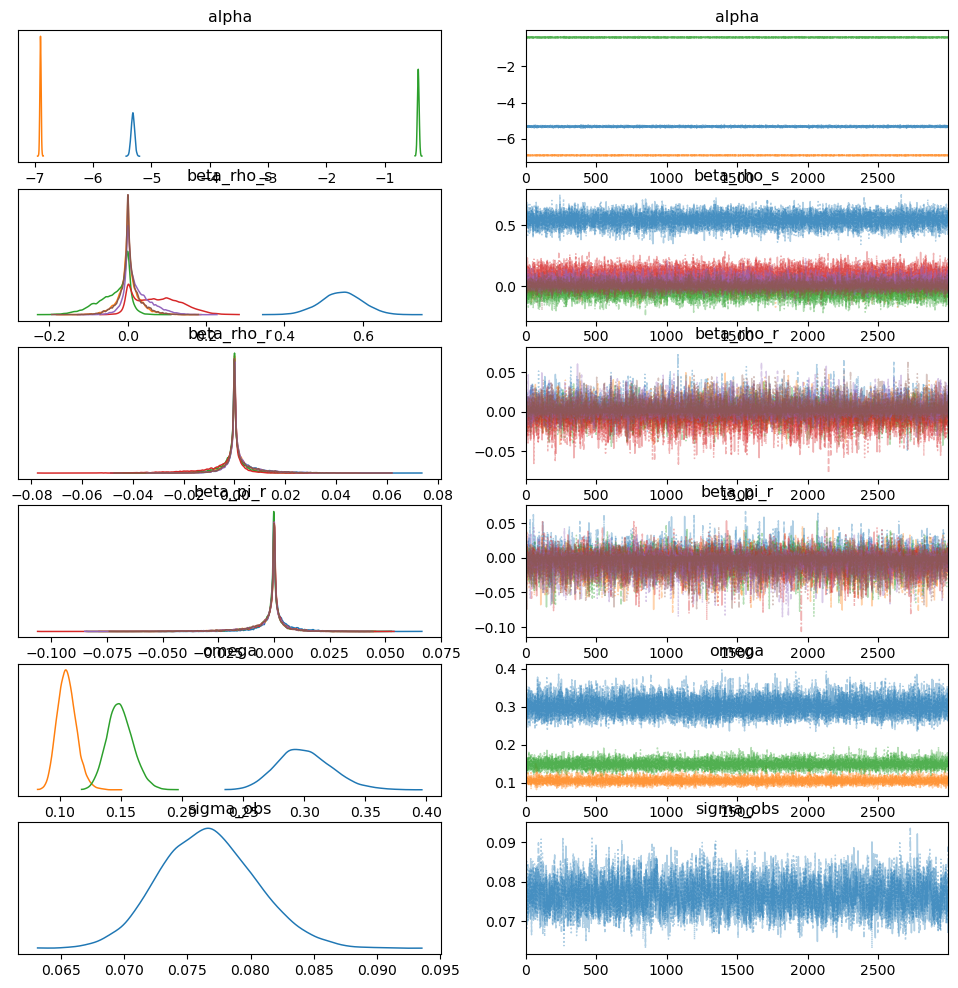

In [10]:
az.plot_trace(idata, var_names=('alpha', 'beta_rho_s', 'beta_rho_r', 'beta_pi_r', 'omega', 'sigma_obs'), combined=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_group_parameters.png")

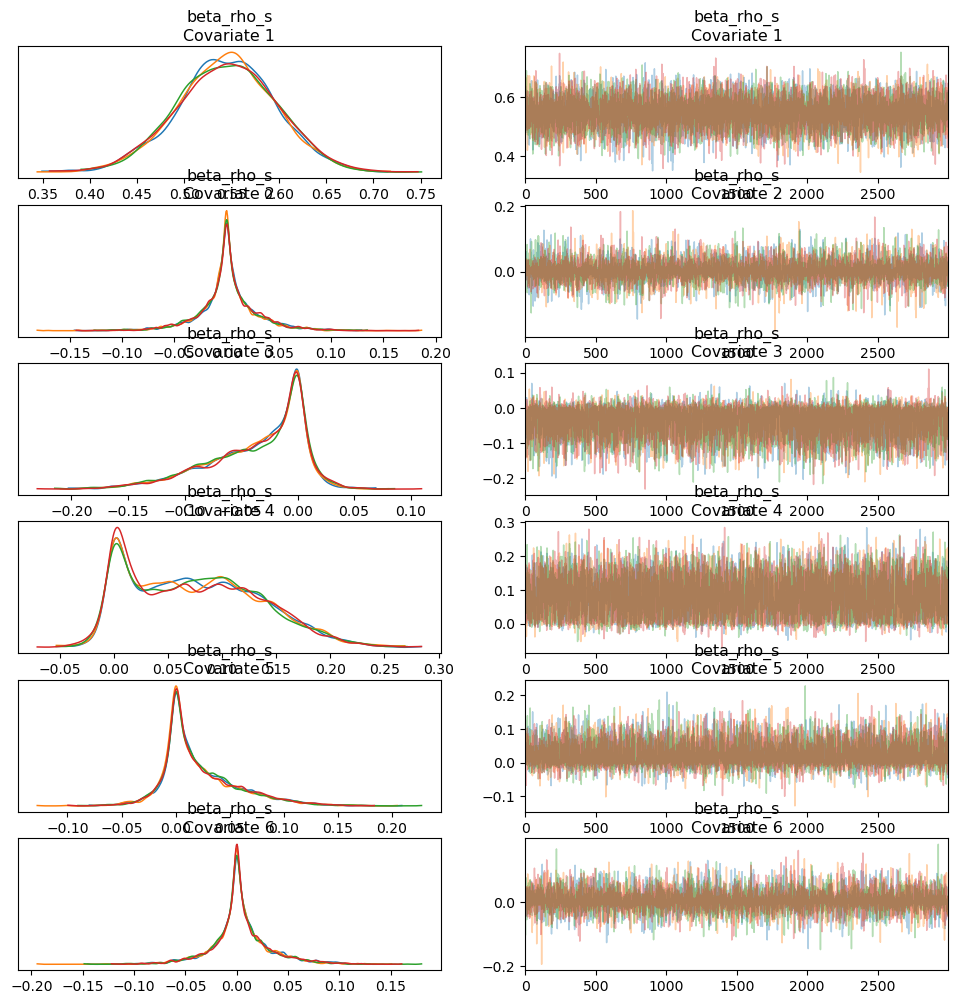

In [11]:
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('beta_rho_s'), lines=[('beta_rho_s', {}, [0])], combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_beta_rho_s.png")
# There seems to be an effect where Age contributes towards higher growth rate for sensitive cells

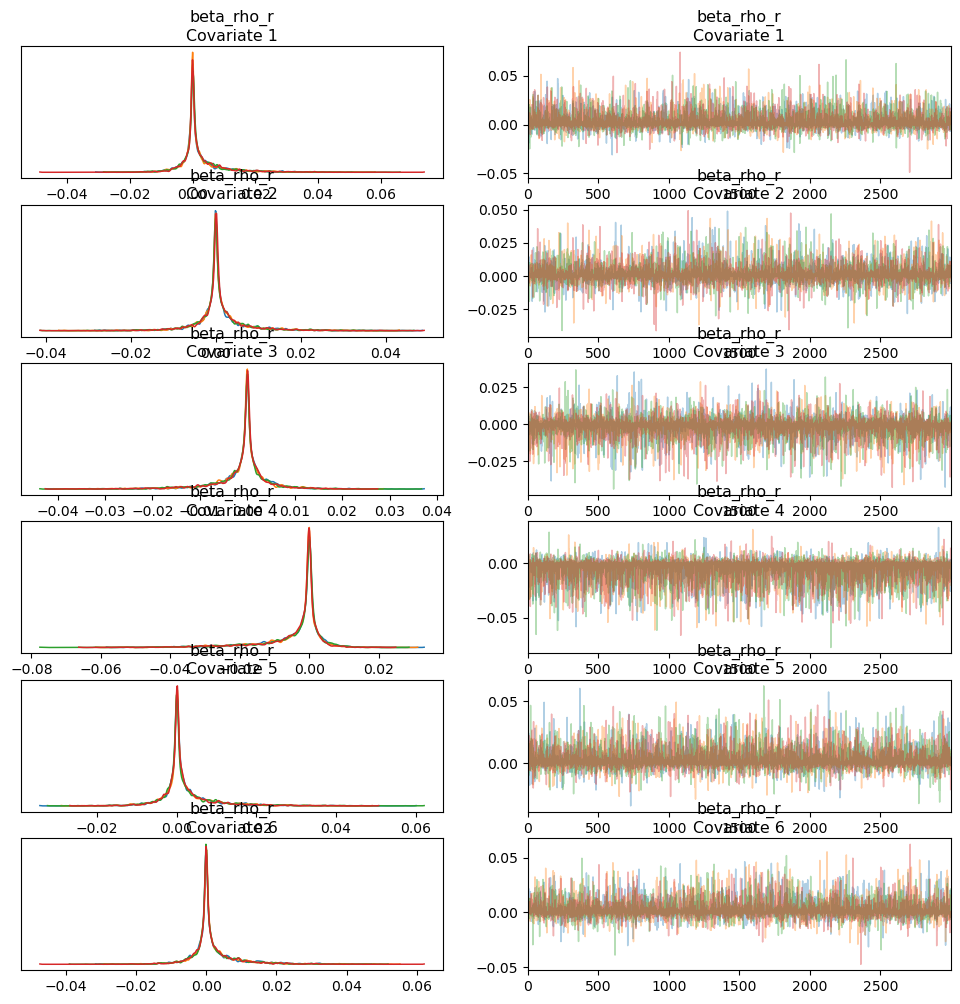

In [12]:
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('beta_rho_r'), lines=[('beta_rho_r', {}, [0])], combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_beta_rho_r.png")

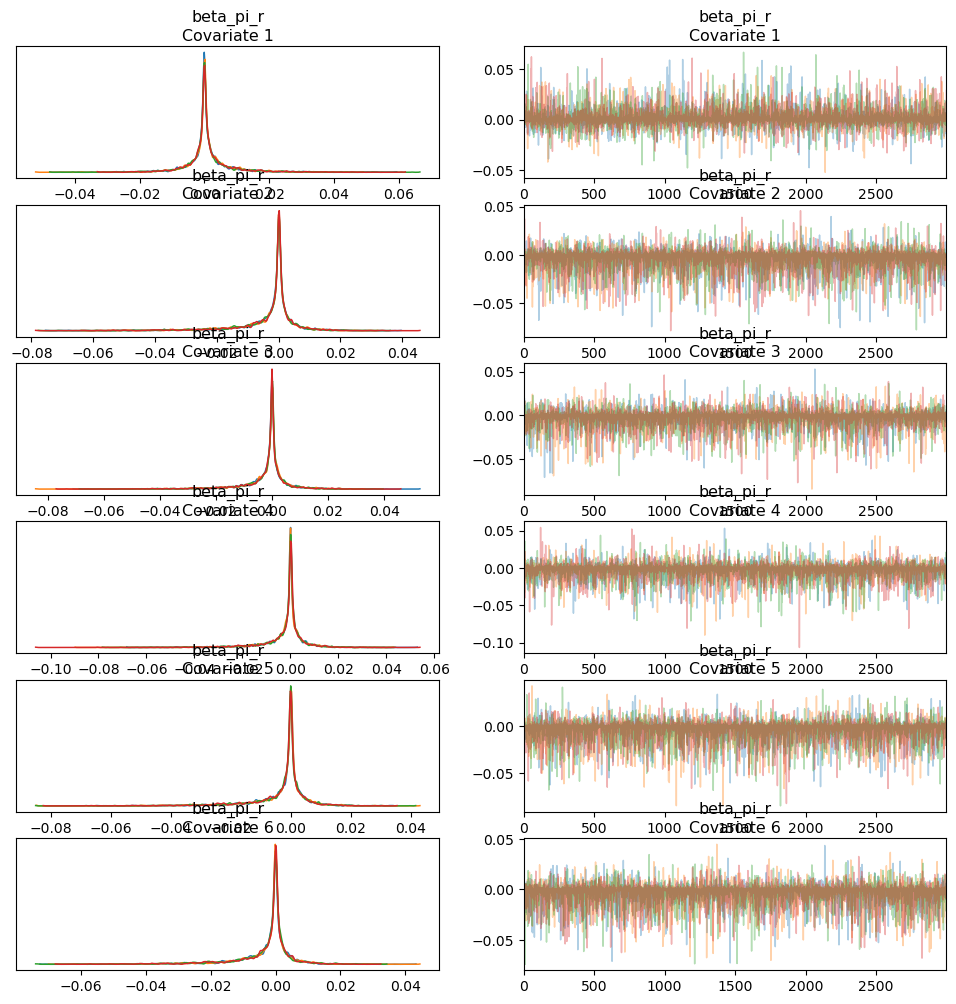

In [13]:
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('beta_pi_r'), lines=[('beta_pi_r', {}, [0])], combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_beta_pi_r.png")
# There is also an effect where there are less resistant cells for the older patients.

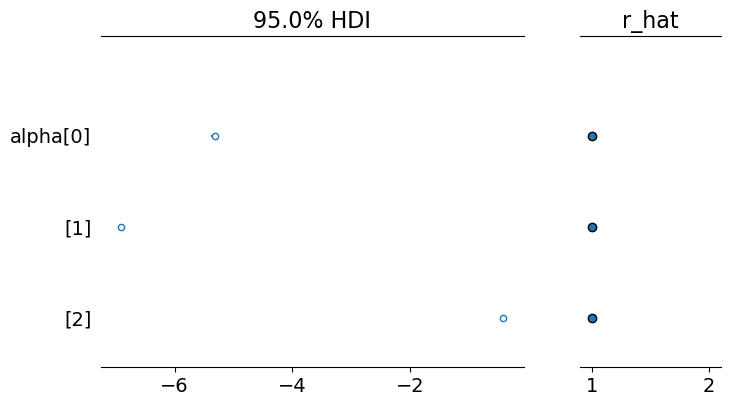

In [14]:
if psi_prior=="lognormal":
    az.plot_trace(idata, var_names=('xi'), combined=True)
    plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_group_parameters_xi.png")
    plt.close()
az.plot_trace(idata, var_names=('theta_rho_s', 'theta_rho_r', 'theta_pi_r', 'rho_s', 'rho_r', 'pi_r'), combined=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_individual_parameters.png")
plt.close()
# Test of exploration 
az.plot_energy(idata)
plt.savefig("./plots/posterior_plots/"+name+"-plot_energy.png")
plt.close()
# Plot of coefficients
az.plot_forest(idata, var_names=["alpha"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_alpha.png")
az.plot_forest(idata, var_names=["beta_rho_s"], combined=True, hdi_prob=0.95, r_hat=True, rope=(0,0))
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_beta_rho_s.png")
plt.close()
az.plot_forest(idata, var_names=["beta_rho_r"], combined=True, hdi_prob=0.95, r_hat=True, rope=(0,0))
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_beta_rho_r.png")
plt.close()
az.plot_forest(idata, var_names=["beta_pi_r"], combined=True, hdi_prob=0.95, r_hat=True, rope=(0,0))
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_beta_pi_r.png")
plt.close()
az.plot_forest(idata, var_names=["theta_rho_s"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_rho_s.png")
plt.close()
az.plot_forest(idata, var_names=["theta_rho_r"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_rho_r.png")
plt.close()
az.plot_forest(idata, var_names=["theta_pi_r"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_pi_r.png")
plt.close()

In [ ]:
# Posterior distribution of alphas, weights, all parameters needed to predict for new patients
sample_shape = idata.posterior['psi'].shape # [chain, n_samples, dim]
n_chains = sample_shape[0]
n_samples = sample_shape[1]
var_dimensions = sample_shape[2] # one per patient
# Gather all the parameter estimates and get y values for each parameter set
posterior_parameters = np.empty(shape=sample_shape, dtype=object)
y_resolution = 1000
predicted_y_values = np.empty((sample_shape+(y_resolution,)))
predicted_y_resistant_values = np.empty_like(predicted_y_values)
for ii in range(var_dimensions): # per patient
    patient = patient_dictionary[ii]
    measurement_times = patient.get_measurement_times()
    treatment_history = patient.get_treatment_history()
    first_time = min(measurement_times[0], treatment_history[0].start)
    plotting_times = np.linspace(first_time, int(measurement_times[-1]), y_resolution) #int((measurement_times[-1]+1)*10))
    for ch in range(n_chains):
        for sa in range(n_samples):
            this_sigma_obs = np.ravel(idata.posterior['sigma_obs'][ch,sa])
            this_psi       = np.ravel(idata.posterior['psi'][ch,sa,ii])
            this_pi_r      = np.ravel(idata.posterior['pi_r'][ch,sa,ii])
            this_rho_s     = np.ravel(idata.posterior['rho_s'][ch,sa,ii])
            this_rho_r     = np.ravel(idata.posterior['rho_r'][ch,sa,ii])
            posterior_parameters[ch,sa,ii] = Parameters(Y_0=this_psi, pi_r=this_pi_r, g_r=this_rho_r, g_s=this_rho_s, k_1=0, sigma=this_sigma_obs)
            these_parameters = posterior_parameters[ch,sa,ii]
            resistant_parameters = Parameters((these_parameters.Y_0*these_parameters.pi_r), 1, these_parameters.g_r, these_parameters.g_s, these_parameters.k_1, these_parameters.sigma)
            # Predicted total M protein
            meas = measure_Mprotein_noiseless(these_parameters, plotting_times, treatment_history)            
            predicted_y_values[ch,sa,ii] = measure_Mprotein_noiseless(these_parameters, plotting_times, treatment_history)            
            # Predicted resistant part
            predicted_y_resistant_values[ch,sa,ii] = measure_Mprotein_noiseless(resistant_parameters, plotting_times, treatment_history)


In [15]:
# Posterior distribution of y values
sample_shape = idata.posterior['psi'].shape # [chain, n_samples, dim]
n_chains = sample_shape[0]
n_samples = sample_shape[1]
var_dimensions = sample_shape[2] # one per patient
# Gather all the parameter estimates and get y values for each parameter set
posterior_parameters = np.empty(shape=sample_shape, dtype=object)
y_resolution = 1000
predicted_y_values = np.empty((sample_shape+(y_resolution,)))
predicted_y_resistant_values = np.empty_like(predicted_y_values)
for ii in range(var_dimensions): # per patient
    patient = patient_dictionary[ii]
    measurement_times = patient.get_measurement_times()
    treatment_history = patient.get_treatment_history()
    first_time = min(measurement_times[0], treatment_history[0].start)
    plotting_times = np.linspace(first_time, int(measurement_times[-1]), y_resolution) #int((measurement_times[-1]+1)*10))
    for ch in range(n_chains):
        for sa in range(n_samples):
            this_sigma_obs = np.ravel(idata.posterior['sigma_obs'][ch,sa])
            this_psi       = np.ravel(idata.posterior['psi'][ch,sa,ii])
            this_pi_r      = np.ravel(idata.posterior['pi_r'][ch,sa,ii])
            this_rho_s     = np.ravel(idata.posterior['rho_s'][ch,sa,ii])
            this_rho_r     = np.ravel(idata.posterior['rho_r'][ch,sa,ii])
            posterior_parameters[ch,sa,ii] = Parameters(Y_0=this_psi, pi_r=this_pi_r, g_r=this_rho_r, g_s=this_rho_s, k_1=0, sigma=this_sigma_obs)
            these_parameters = posterior_parameters[ch,sa,ii]
            resistant_parameters = Parameters((these_parameters.Y_0*these_parameters.pi_r), 1, these_parameters.g_r, these_parameters.g_s, these_parameters.k_1, these_parameters.sigma)
            # Predicted total M protein
            meas = measure_Mprotein_noiseless(these_parameters, plotting_times, treatment_history)            
            predicted_y_values[ch,sa,ii] = measure_Mprotein_noiseless(these_parameters, plotting_times, treatment_history)            
            # Predicted resistant part
            predicted_y_resistant_values[ch,sa,ii] = measure_Mprotein_noiseless(resistant_parameters, plotting_times, treatment_history)


In [ ]:
print(predicted_y_values[0,0,0].shape)
print(predicted_y_resistant_values[0,0,0].shape)

# Group measurements by patient and time
flat_pred_y_values = np.reshape(predicted_y_values, (n_chains*n_samples,var_dimensions,1000))
# sort the arrays of y
sorted_pred_y_values = np.sort(flat_pred_y_values, axis=0)
print(sorted_pred_y_values.shape)

In [ ]:
# Plot posterior confidence intervals 
for training_instance_id, patient in patient_dictionary.items():
    savename = "./plots/Bayesian_estimates_simdata_linearmodel/CI_training_id_"+str(training_instance_id)+"_M_"+str(M_number_of_measurements)+"_P_"+str(P)+"_N_cases_"+str(N_cases)+"_psi_prior_"+psi_prior+"_N_samples_"+str(N_samples)+".png"
    plot_posterior_confidence_intervals(training_instance_id, patient, sorted_pred_y_values, parameter_estimates=[], PLOT_POINT_ESTIMATES=False, PLOT_TREATMENTS=False, plot_title="Posterior CI for patient "+str(training_instance_id), savename=savename, y_resolution=y_resolution, n_chains=n_chains, n_samples=n_samples)

In [ ]:
# Prediction for unseen patients: Compare their Y values as predicted by X with their true Y values given their simulated theta. 

# Generate X
N_patients_test = 20
X_test = np.random.uniform(-1, 1, size=(N_patients_test,P))
X_test = pd.DataFrame(X, columns = ["Covariate "+str(ii+1) for ii in range(P)])

expected_theta_1_test = np.reshape(true_alpha[0] + np.dot(X_test, true_beta_rho_s) + np.ravel(interaction_beta*X["Covariate 1"]*(X_test["Covariate 2"].T)), (N_patients_test,1))
expected_theta_2_test = np.reshape(true_alpha[1] + np.dot(X_test, true_beta_rho_r), (N_patients_test,1))
expected_theta_3_test = np.reshape(true_alpha[2] + np.dot(X_test, true_beta_pi_r), (N_patients_test,1))

true_theta_rho_s_test = np.random.normal(expected_theta_1_test, true_omega[0])
true_theta_rho_r_test = np.random.normal(expected_theta_2_test, true_omega[1])
true_theta_pi_r_test  = np.random.normal(expected_theta_3_test, true_omega[2])

true_theta_psi_test = np.random.normal(np.log(psi_population), true_omega_for_psi, size=N_patients_test)
true_rho_s_test = - np.exp(true_theta_rho_s_test)
true_rho_r_test = np.exp(true_theta_rho_r_test)
true_pi_r_test  = 1/(1+np.exp(-true_theta_pi_r_test))
true_psi_test = np.exp(true_theta_psi_test)

# Generate new patients
patient_dictionary_test = {}
for test_id in range(N_patients):
    psi_patient_i   = true_psi_test[test_id]
    pi_r_patient_i  = true_pi_r_test[test_id]
    rho_r_patient_i = true_rho_r_test[test_id]
    rho_s_patient_i = true_rho_s_test[test_id]
    these_parameters = Parameters(Y_0=psi_patient_i, pi_r=pi_r_patient_i, g_r=rho_r_patient_i, g_s=rho_s_patient_i, k_1=0, sigma=true_sigma_obs)
    this_patient = Patient(these_parameters, measurement_times, treatment_history, name=str(test_id))
    patient_dictionary_test[test_id] = this_patient
    #plot_true_mprotein_with_observations_and_treatments_and_estimate(these_parameters, this_patient, estimated_parameters=[], PLOT_ESTIMATES=False, plot_title=str(test_id), savename="./plots/Bayes_simulated_data/"+str(test_id))

sorted_pred_y_values_test = 

for test_id, patient in patient_dictionary_test.items():
    savename = "./plots/Bayesian_estimates_simdata_linearmodel/CI_test_id_"+str(test_id)+"_M_"+str(M_number_of_measurements)+"_P_"+str(P)+"_N_cases_"+str(N_cases)+"_psi_prior_"+psi_prior+"_N_samples_"+str(N_samples)+".png"
    plot_posterior_confidence_intervals(test_id, patient, sorted_pred_y_values_test, parameter_estimates=patient.parameters, PLOT_POINT_ESTIMATES=True, PLOT_TREATMENTS=False, plot_title="Posterior predictive CI for patient "+str(test_id), savename=savename, y_resolution=y_resolution, n_chains=n_chains, n_samples=n_samples)



In [ ]:
# Posterior median M protein 
median_sigma_obs   = np.median(idata.posterior['sigma_obs'])
print("Median sigma_obs:", median_sigma_obs)
median_psi_all_patients   = np.median(idata.posterior['psi'],   axis=(0,1))
median_pi_r_all_patients  = np.median(idata.posterior['pi_r'],  axis=(0,1))
median_rho_s_all_patients = np.median(idata.posterior['rho_s'], axis=(0,1))
median_rho_r_all_patients = np.median(idata.posterior['rho_r'], axis=(0,1))

# Dictionary of parameter estimates indexed by training_instance_id
estimated_parameters_dict = {}
for ii in range(N_cases): #ii = training_instance_id
    estimated_parameters_dict[ii] = Parameters(Y_0=median_psi_all_patients[ii], pi_r=median_pi_r_all_patients[ii], g_r=median_rho_r_all_patients[ii], g_s=median_rho_s_all_patients[ii], k_1=0, sigma=median_sigma_obs)
print("First patient's median parameters:", estimated_parameters_dict[0].to_array_with_sigma())

# Plot patient estimates
for training_instance_id, patient in patient_dictionary.items():
    estimated_parameters = estimated_parameters_dict[training_instance_id]
    #patient.print()
    savename = "./plots/Bayesian_estimates_simdata_linearmodel/training_id_"+str(training_instance_id)+"_M_"+str(M_number_of_measurements)+"_P_"+str(P)+"_N_cases_"+str(N_cases)+"_psi_prior_"+psi_prior+"_N_samples_"+str(N_samples)+"_median_parameters__Y_0="+str(estimated_parameters.Y_0)+", pi_r="+str(estimated_parameters.pi_r)+", g_r="+str(estimated_parameters.g_r)+", g_s="+str(estimated_parameters.g_s)+", k_1="+str(estimated_parameters.k_1)+", sigma="+str(estimated_parameters.sigma)+".png"
    plot_treatment_region_with_estimate(estimated_parameters, patient, estimated_parameters=[], PLOT_ESTIMATES=False, plot_title="Posterior median for "+str(training_instance_id), savename=savename)
